In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
# Copy the dataframe from drive 
!cp '/content/gdrive/MyDrive/Colab Notebooks/hERG_dataset.csv' /content/
# Unmount the gdrive
drive.flush_and_unmount()

Mounted at /content/gdrive


In [2]:
# Install RDKit and SHAP
!pip install rdkit
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import shap
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from rdkit import DataStructs
from rdkit.Chem import Descriptors

from statistics import mean, stdev

import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("hERG_dataset.csv")

In [5]:
df["smiles"].isnull().sum() #check whether include null or not

0

In [6]:
#df['activity'].value_counts()[0]
#df['activity'].value_counts()[1]
print(f"Toxic compounds {df['activity'].value_counts()[1]} and Non-toxic compounds {df['activity'].value_counts()[0]}")

Toxic compounds 2164 and Non-toxic compounds 5990


In [7]:
df["mols"] = df["smiles"].apply(lambda x: Chem.MolFromSmiles(x)) #creating moles
df["fingerprints"] = df["mols"].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024)) #assigning fingerprints to the mols

In [30]:
df

,smiles,activity,mols,fingerprints
0,COc1ccc([C@@H](O)C[C@H]2c3cc(OC)c(OC)cc3CCN2C)cc1,1,<rdkit.Chem.rdchem.Mol object at 0x7f4f8f0bce40>,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1nnc(N2CC[C@@H](F)C2)c2nn(-c3ccc(OCC(F)(F)F)...,1,<rdkit.Chem.rdchem.Mol object at 0x7f4f8f0bcf20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=c1n(Cc2ccccc2)c2sc3c(c2c2ncnn12)CCN(CC1CCOCC...,1,<rdkit.Chem.rdchem.Mol object at 0x7f4f8f0bceb0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,COCCCc1cc(CN(C(=O)[C@H]2CNCC[C@@H]2c2ccc(OCCOc...,1,<rdkit.Chem.rdchem.Mol object at 0x7f4f8f0bcf90>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."
4,CC1(C)C2=C3C=C4C5=[N+](CCC4OC3CCN2c2ccc(CC(=O)...,1,<rdkit.Chem.rdchem.Mol object at 0x7f4f8f061040>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ..."
...,...,...,...,...
8149,C#C[C@]1(OC(C)=O)CC[C@H]2[C@@H]3CCC4=C/C(=N/O)...,0,<rdkit.Chem.rdchem.Mol object at 0x7f4f8efcd430>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
8150,CC1=C(C=C/C(C)=C/C=C/C(C)=C/C(=O)Oc2c(C)c(C)c3...,0,<rdkit.Chem.rdchem.Mol object at 0x7f4f8efcd4a0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8151,COC(=O)CCC[N+](C)(C)C,0,<rdkit.Chem.rdchem.Mol object at 0x7f4f8efcd510>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
8152,C[N+]1(CC2COC(c3ccccc3)(C3CCCCC3)O2)CCCCC1,0,<rdkit.Chem.rdchem.Mol object at 0x7f4f8efcd580>,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [9]:
X = df["fingerprints"]
y = df["activity"]

In [10]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [11]:
# STRATIFIED CV IMPLEMENTATION
def get_metrics(fold, model, test, pred, test_prob):
  d = {
    "model": model,
    "fold": fold,
    "c_report": classification_report(test, pred),
    "accuracy": accuracy_score(test, pred),
    "sensivity": recall_score(test, pred),
    "specificity": recall_score(test, pred, pos_label=0),
    "auc": roc_auc_score(test, test_prob),
  }
  return d

# Define the Models
svm = SVC(kernel="linear", probability=True)
dt = DecisionTreeClassifier()
nn = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000)

skf = StratifiedKFold(n_splits=5)

model_metrics = pd.DataFrame(columns=["model", "fold", "c_report", "accuracy", "sensivity", "specificity", "auc"])

for fold, (train_index, test_index) in enumerate(skf.split(df_X_train, df_y_train)):
  print(f"Fold {fold}")
  X_train_fold = df_X_train.iloc[train_index].tolist()
  y_train_fold = df_y_train.iloc[train_index].tolist()
  X_test_fold = df_X_train.iloc[test_index].tolist()
  y_test_fold = df_y_train.iloc[test_index].tolist()

  # SVM
  svm.fit(X_train_fold, y_train_fold)  
  y_pred_fold = svm.predict(X_test_fold)
  test_prob_fold = svm.predict_proba(X_test_fold)[:, 1]
  model_metrics = model_metrics.append(get_metrics(fold, "SVM", y_test_fold, y_pred_fold, test_prob_fold), ignore_index=True)

  # DT
  dt.fit(X_train_fold, y_train_fold)
  y_pred_fold = dt.predict(X_test_fold)
  test_prob_fold = dt.predict_proba(X_test_fold)[:, 1]
  model_metrics = model_metrics.append(get_metrics(fold, "DT", y_test_fold, y_pred_fold, test_prob_fold), ignore_index=True)

  # NN
  nn.fit(X_train_fold, y_train_fold)  
  y_pred_fold = nn.predict(X_test_fold)
  test_prob_fold = nn.predict_proba(X_test_fold)[:, 1]
  model_metrics = model_metrics.append(get_metrics(fold, "NN", y_test_fold, y_pred_fold, test_prob_fold), ignore_index=True)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4


In [12]:
model_metrics

,model,fold,c_report,accuracy,sensivity,specificity,auc
0,SVM,0,precision recall f1-score ...,0.844444,0.676301,0.905109,0.882784
1,DT,0,precision recall f1-score ...,0.811494,0.641618,0.872784,0.757531
2,NN,0,precision recall f1-score ...,0.861303,0.713873,0.914494,0.890936
3,SVM,1,precision recall f1-score ...,0.828352,0.687861,0.879041,0.864463
4,DT,1,precision recall f1-score ...,0.824521,0.687861,0.873827,0.781619
5,NN,1,precision recall f1-score ...,0.842146,0.708092,0.890511,0.863323
6,SVM,2,precision recall f1-score ...,0.848276,0.708934,0.898747,0.884428
7,DT,2,precision recall f1-score ...,0.826820,0.645533,0.892484,0.768084
8,NN,2,precision recall f1-score ...,0.869732,0.749280,0.913361,0.888116
9,SVM,3,precision recall f1-score ...,0.835890,0.713873,0.879958,0.873787


In [13]:
X_train = df_X_train.tolist() #converting fingerprints train data to list first and then np array
X_test = df_X_test.tolist() #converting fingerprints test data to list first and then np array
y_train = df_y_train.tolist() #converting activities train data to list first and then np array
y_test = df_y_test.tolist() #converting activities test data to list first and then np array

In [14]:
# Train a SVM model
svm.fit(X_train, y_train)

# Predict
y_pred_svm = svm.predict(X_test)
test_prob_svm = svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, test_prob_svm)

In [15]:
# Train the Decision Tree model
dt.fit(X_train, y_train)

# Predict
y_pred_dt = dt.predict(X_test)
test_prob_dt = dt.predict_proba(X_test)[:, 1]
auc_dt = roc_auc_score(y_test, test_prob_dt)

In [16]:
# Train the Neural Network model
nn.fit(X_train, y_train)

# Predict
y_pred_nn = nn.predict(X_test)
test_prob_nn = nn.predict_proba(X_test)[:, 1]
auc_nn = roc_auc_score(y_test, test_prob_nn)

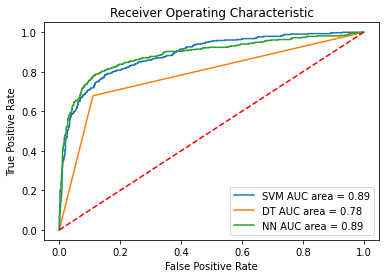

In [17]:
fig, ax = plt.subplots()

# Compute False postive rate and True positive rate
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, test_prob_svm)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(y_test, test_prob_dt)
fpr_nn, tpr_nn, thresholds_nn = metrics.roc_curve(y_test, test_prob_nn)

# Plot the computed values
ax.plot(fpr_svm, tpr_svm, label=(f"SVM AUC area = {auc_svm:.2f}"))
ax.plot(fpr_dt, tpr_dt, label=(f"DT AUC area = {auc_dt:.2f}"))
ax.plot(fpr_nn, tpr_nn, label=(f"NN AUC area = {auc_nn:.2f}"))

# Custom settings for the plot
ax.plot([0, 1], [0, 1], "r--")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic")
ax.legend(loc="lower right")

In [29]:
print("------------ Stratified 5-fold Cross Validation ------------")
print("SVM: ")
print(f'Accuracy Mean: {model_metrics[model_metrics.model == "SVM"].accuracy.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "SVM"].accuracy.std()}')
print(f'Sensivity Mean: {model_metrics[model_metrics.model == "SVM"].sensivity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "SVM"].sensivity.std()}')
print(f'Specificity Mean: {model_metrics[model_metrics.model == "SVM"].specificity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "SVM"].specificity.std()}')
print(f'AUC Mean: {model_metrics[model_metrics.model == "SVM"].auc.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "SVM"].auc.std()}')
print("\nDT: ")
print(f'Accuracy Mean: {model_metrics[model_metrics.model == "DT"].accuracy.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "DT"].accuracy.std()}')
print(f'Sensivity Mean: {model_metrics[model_metrics.model == "DT"].sensivity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "DT"].sensivity.std()}')
print(f'Specificity Mean: {model_metrics[model_metrics.model == "DT"].specificity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "DT"].specificity.std()}')
print(f'AUC Mean: {model_metrics[model_metrics.model == "DT"].auc.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "DT"].auc.std()}')
print("\nNN: ")
print(f'Accuracy Mean: {model_metrics[model_metrics.model == "NN"].accuracy.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "NN"].accuracy.std()}')
print(f'Sensivity Mean: {model_metrics[model_metrics.model == "NN"].sensivity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "NN"].sensivity.std()}')
print(f'Specificity Mean: {model_metrics[model_metrics.model == "NN"].specificity.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "NN"].specificity.std()}')
print(f'AUC Mean: {model_metrics[model_metrics.model == "NN"].auc.mean()} \tStandard Deviation: {model_metrics[model_metrics.model == "NN"].auc.std()}')

print("\n------------ Stratified 80/20 Split ------------")
print("SVM: ")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_svm)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred_svm)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"Sensitivity: {recall_score(y_test, y_pred_svm)}")
print(f"Specificity: {recall_score(y_test, y_pred_svm, pos_label=0)}")
print(f"AUC: {auc_svm}")
print("\nDT: ")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_dt)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred_dt)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Sensitivity: {recall_score(y_test, y_pred_dt)}")
print(f"Specificity: {recall_score(y_test, y_pred_dt, pos_label=0)}")
print(f"AUC: {auc_dt}")
print("\nNN: ")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred_nn)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred_nn)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")
print(f"Sensitivity: {recall_score(y_test, y_pred_nn)}")
print(f"Specificity: {recall_score(y_test, y_pred_nn, pos_label=0)}")
print(f"AUC: {auc_nn}")

------------ Stratified 5-fold Cross Validation ------------
SVM: 
Accuracy Mean: 0.8385703876078321 	Standard Deviation: 0.007865744740946675
Sensivity Mean: 0.6949659342672951 	Standard Deviation: 0.015826542190792346
Specificity Mean: 0.8904417223055505 	Standard Deviation: 0.011458627072332538
AUC Mean: 0.8753494576453807 	Standard Deviation: 0.008294105047259982

DT: 
Accuracy Mean: 0.8256958841642573 	Standard Deviation: 0.00881192672380233
Sensivity Mean: 0.6713031600339824 	Standard Deviation: 0.026660903033205577
Specificity Mean: 0.8814725237884801 	Standard Deviation: 0.009324937271982883
AUC Mean: 0.7767405178849126 	Standard Deviation: 0.013655321371146412

NN: 
Accuracy Mean: 0.8560470582704557 	Standard Deviation: 0.011359033194435469
Sensivity Mean: 0.7151738268561243 	Standard Deviation: 0.01965886326003326
Specificity Mean: 0.9069300615420115 	Standard Deviation: 0.011700608430885622
AUC Mean: 0.8726354948461019 	Standard Deviation: 0.01557605234696987

------------ S

In [21]:
# Sample a smaller number of molecules to be analysed

# df.loc[X_train.loc[y_train == 0].index]['activity'].value_counts
X_sample_n = df_X_test.loc[df_y_test == 0].sample(5)
X_sample_p = df_X_test.loc[df_y_test == 1].sample(5)
X_train_sample_n = df_X_train.loc[df_y_train == 0].sample(10)
X_train_sample_p = df_X_train.loc[df_y_train == 1].sample(10)

X_sample = X_sample_n
X_sample = X_sample.append(X_sample_p)
X_train_sample = X_train_sample_n
X_train_sample = X_train_sample.append(X_train_sample_p)

X_sample_copy = X_sample

# Check if samples are collected correctly
# y_test.loc[X_sample_p.index]
# y_test.loc[X_sample_n.index]
# y_train.loc[X_train_sample_p.index]
# y_train.loc[X_train_sample_n.index]

# Convert to np.array
X_sample = np.array(X_sample.tolist())
X_train_sample = np.array(X_train_sample.tolist())

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

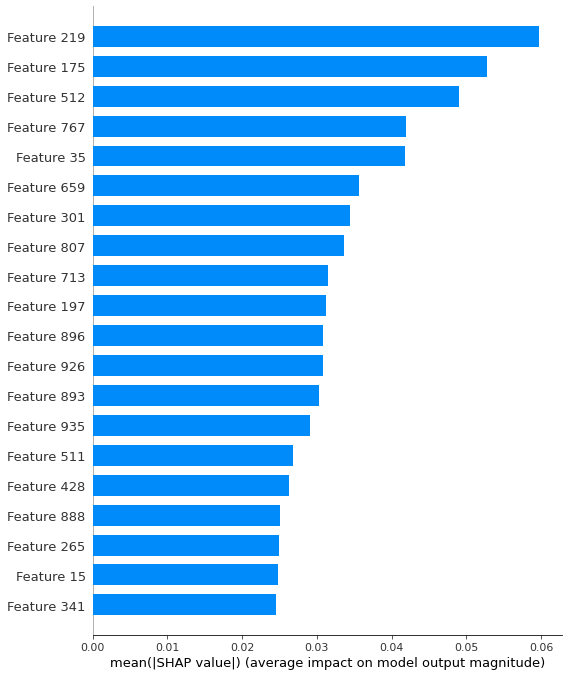

In [22]:
# Initialise the SHAP Kernel Explainer
explainer_svm = shap.KernelExplainer(svm.predict, X_train_sample)

# Compute Shapley values
shap_values_svm = explainer_svm.shap_values(X_sample)

# Assess whether certain bit appear more often than others
shap.summary_plot(shap_values_svm, X_sample, plot_type="bar")

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

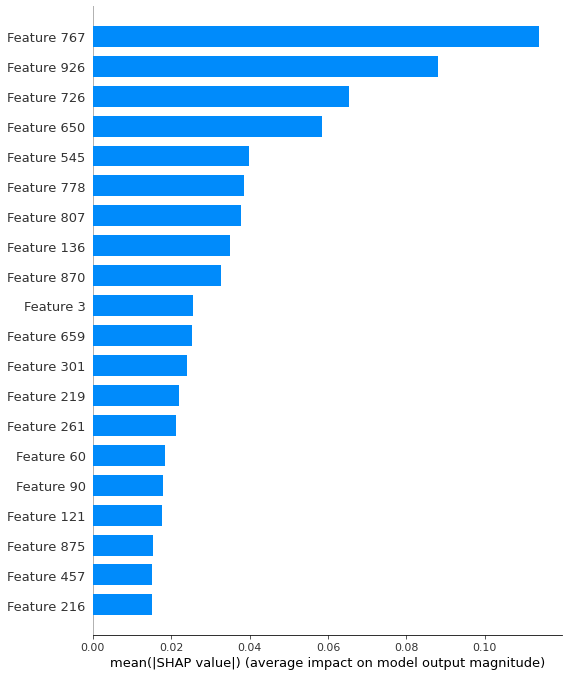

In [23]:
#Initialise the SHAP Kernel Explainer
explainer_dt = shap.KernelExplainer(dt.predict, X_train_sample)

# Compute Shapley values
shap_values_dt = explainer_dt.shap_values(X_sample)

# Assess whether certain bit appear more often than others
shap.summary_plot(shap_values_dt, X_sample, plot_type="bar")

  0%|          | 0/10 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

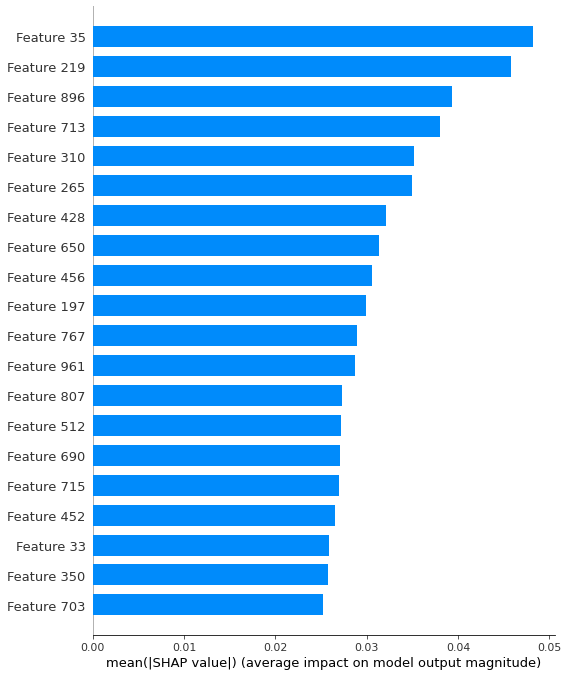

In [24]:
#Initialise the SHAP Kernel Explainer
explainer_nn = shap.KernelExplainer(nn.predict, X_train_sample)

# Compute Shapley values
shap_values_nn = explainer_nn.shap_values(X_sample)

# Assess whether certain bit appear more often than others
shap.summary_plot(shap_values_nn, X_sample, plot_type="bar")

In [25]:
print(shap_values_svm)

[[ 0.          0.01165798  0.         ...  0.          0.
   0.        ]
 [ 0.         -0.00427646  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00435255  0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.00827877  0.         ...  0.          0.
   0.        ]]


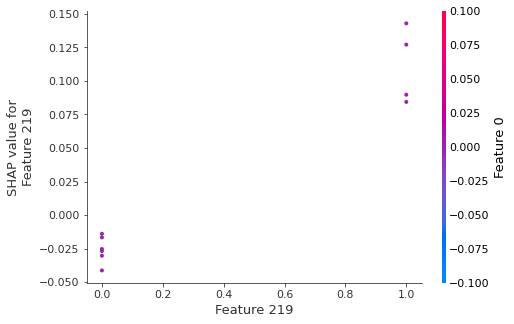

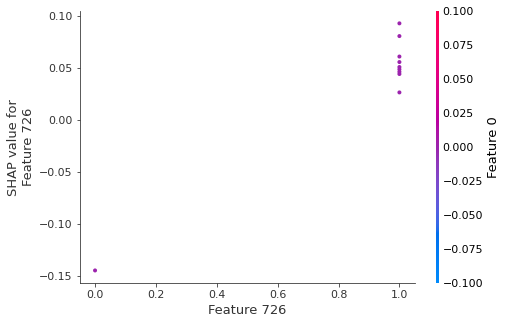

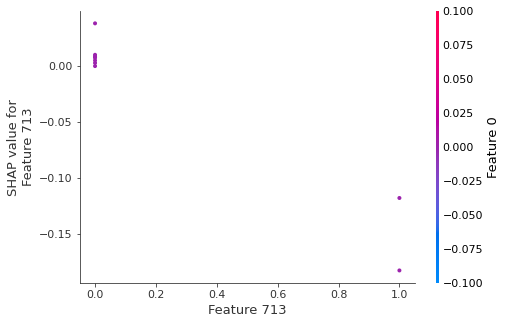

In [26]:
# Compare the Shapley values for thhe three models
shap.dependence_plot("rank(0)", shap_values_svm, X_sample)
shap.dependence_plot("rank(2)", shap_values_dt, X_sample)
shap.dependence_plot("rank(3)", shap_values_nn, X_sample)
#Plots the value of the feature on the x-axis and the SHAP value of the same feature on the y-axis. This shows how the model depends on the given feature, and is like a richer extenstion of the classical parital dependence plots. Vertical dispersion of the data points represents interaction effects.

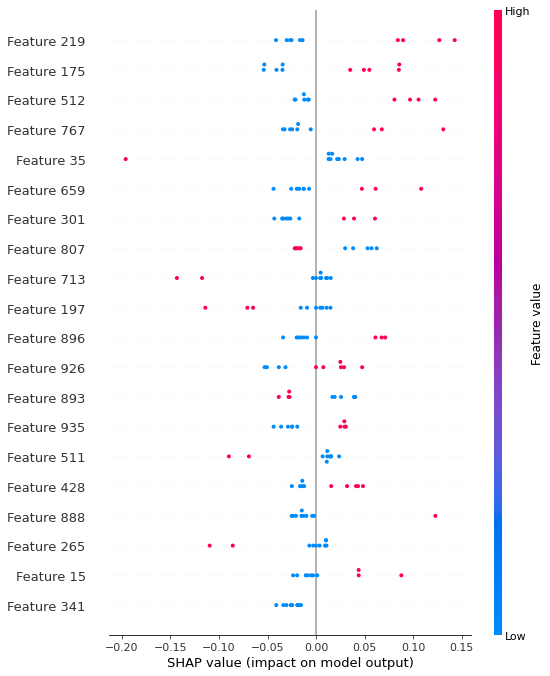

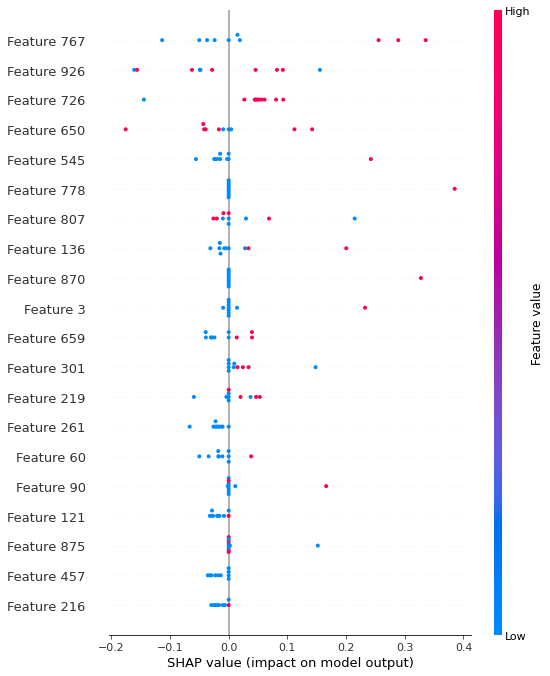

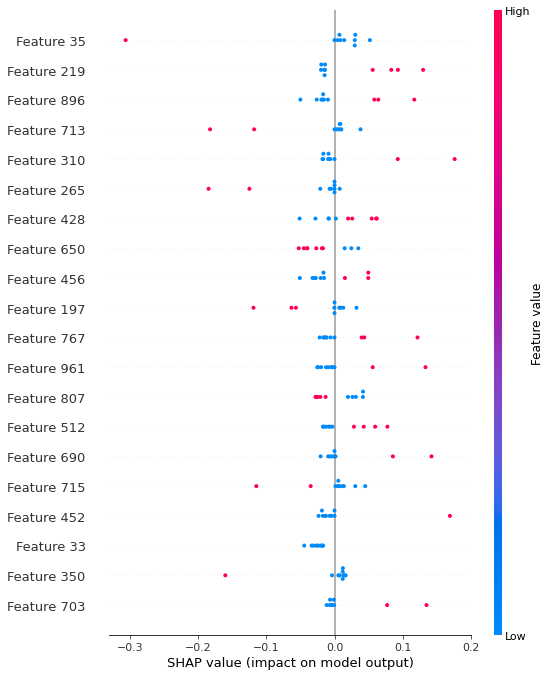

In [27]:
#Visualize the Shapley values for each molecule
shap.summary_plot(shap_values_svm, X_sample)
shap.summary_plot(shap_values_dt, X_sample)
shap.summary_plot(shap_values_nn, X_sample)